# Section II: Some fundamentals


In [609]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing, sklearn.linear_model, sklearn.datasets
import sklearn.svm, sklearn.cross_validation, sklearn.grid_search, sklearn.metrics, sklearn.decomposition
import scipy.spatial
import seaborn
import scipy.special
import scipy.stats as stats
# force plots to appear inline on this page
%matplotlib inline

## Overfitting and regularisation
### Overfitting 
We saw examples of overfitting in the previous lecture. Preventing overfitting is one of the major challenges of machine learning. It is easy to build models that can approximate any function; but approximating in a way that generalises to unseen data is much harder.

Enforcing structure to minimise overfitting is called *regularisation*. Techniques such as *bagging* or *bootstrap* methods that we saw in the previous lecture are examples of randomised approaches to regularisation.  By forcing learning algorithms to learn from impoverished datasets and then averaging the results, we can prevent the learning from conforming into the irrelvant "nooks and crannies" of the functions to be learned.





### Penalisation
An alternative approach is to explicitly penalise functions for getting too complicated. This is called *penalisation* and is widely used in statistical modelling. An explicit *penalty function* is defined which applies a constraint to the optimisation of parameters to force the function being learned to stay "smooth".

Developing a penalty function is tricky, as it is not always clear how enforcing constraints of the *parameters* of a learning algorithm affects the generalisation properties of the result. However, there are many well-developed techniques for which good penalty function are known.

#### Lasso / ridge regression
One common approach is to apply penalties when fitting a linear model (i.e. $y=Ax$) that constrain the values of linear fit to be small. The specific *norm* used to measure the size of the coefficients gives rise to various regularisation approaches.

An approach which forces the coefficients to be small in the $L_2$ norm (i.e. the Euclidean distance of the coefficient vector to the origin) is called *ridge regression*; using the $L_1$ norm (the sum of coefficient values) is called lasso regression.







In [ ]:
# FIXME
n = 100

x = np.random.uniform(-1,1,(n,1))
y = 4*x[:,0] 
y[10] = 200
plt.scatter(x,y)

# simple univariate regression 

for n in range(20):
    ridge = sklearn.linear_model.Ridge(alpha=100*np.exp(-n), fit_intercept=True)
    ridge.fit(x,y)
    # predict output
    xs = np.linspace(-1,1,100)[:, None]
    ys = ridge.predict(xs)
    plt.plot(xs,ys)
    plt.ylim(-5,5)




## Probabilistic approaches
#### Random variables
A *random variable* is a variable that can take on different values; i.e. one that is "unassigned". Proability theory allows us to manipulate random variables without having to assign them a specific value.

#### Distributions
A *probability* distribution defines how likely different states of a random variable are. The probability distribution of a random variable $x$ is written:
$$P(x)$$
Random variables can be continuous (e.g. the height of a person) or discrete (the value showing on the face of a dice). The distribution of a discrete variable is described with a *probability mass function* (PMF) which gives each outcome a specific value. A continuous variable has a *probability density function* (PDF) which specifies the spread of the probability as a continuous function.

A probability distribution must assign probabilities in the range 0 (impossible) to 1 (definite) and the PMF or PDF **must** integrate to exactly 1 as the random variable under consideration must take on *some* value. Note that a **PDF** can have a value >1 if the integral of the function is still = 1. A PMF always has $P(x)<1 \forall x$




In [ ]:
# the PMF of the sum of two dice rolls
def two_dice():
    # form the sum of the cross product of these possibilities
    roll_two = [i+j for i in range(6) for j in range(6)]
    # now plot the histogram
    plt.hist(roll_two, normed=True, bins=range(12))
    plt.xlabel("Sum of rolls x")
    plt.ylabel("P(x)")


In [ ]:
two_dice()

In [ ]:
# Plot the PDF of the normal distribution
def plot_normal():
    # plot the normal (Gaussian distibution) along with a set of points drawn from that distribution
    x = np.linspace(-4,4,100)
    y = stats.norm.pdf(x) # mean 0, std. dev. 1
    plt.plot(x,y)
    plt.axhline(0, color='k', linewidth=0.2) # axis line
 
    # mark the mean
    plt.text(0, 0.51, '$\mu$')
    plt.axvline(0, color='r')
    # highlight one std. dev. to the right
    plt.axvspan(0,1, facecolor='b', alpha=0.1)
    plt.text(1.2, 0.3, '$\sigma$')
    # take 1000 random samples and scatter plot them
    samples = stats.norm.rvs(0,1,1000)
    plt.scatter(samples, np.full(samples.shape, .2), s=4, c='b', alpha=0.03)
    plt.xlabel("$x$")
    plt.ylabel("$P(x)$")
    

In [ ]:
plot_normal()

### Joint, marginal, conditional
The *joint probability* of two random variables is written $$P(x,y)$$ and gives the probability that $x$ and $y$ take the same value simultaneously. The *marginal probability* is the derivation of $P(x)$ from $P(x,y)$ by integrating (summing) over all the possible choices of $y$:
$$P(x) = \int P(x,y) dy$$

Two random variables are *independent* if the they do not have any dependence on each other. If this is the case then the joint distribution is just the product of the individual distributions:
$p(x,y) = p(x)p(y)$

The *conditional probability* of $x$ **given** $y$ is written as $$p(x|y)$$ and can be computed as $$p(x|y) = \frac{p(x,y)}{p(x)}$. This tells us how likely $x$ is to occur if we already know  (or fix) the value of $y$.

The *expected value* of a random variable with respect to a function is the function weighted by the probability at each point:
$$E[f(x)] = \int p(x)f(x) dx$$
or
$$E[f(x)] = \sum_{x} p(x)f(x)$$ in the discrete case. 

The *variance* of a random variable is a measure of spread, and can be computed from a nested expectation:
$$\textrm{Var}(f(x)) = E[(f(x) - E[(f(x)])^2]$$

These concepts are easier to see visually.


In [ ]:
def joint_marginal(cov):
    # create an independent 2D normal distribution
    x,y = np.meshgrid(np.linspace(-3,3,50), np.linspace(-3,3,50))
    pos = np.empty(x.shape + (2,))
    pos[:,:,0] = x
    pos[:,:,1] = y
    joint_pdf = stats.multivariate_normal.pdf(pos, [0,0], cov)
    fig = plt.figure()
    # plot the joint
    ax = fig.add_subplot(2,2,1)
    ax.axis('equal')
    ax.pcolor(x,y,joint_pdf, cmap='gist_heat')
    # plot the marginals
    ax = fig.add_subplot(2,2,3)
    ax.axis('equal')
    
    ax.plot(x[0,:], np.sum(joint_pdf, axis=0))
    ax = fig.add_subplot(2,2,2)
    ax.axis('equal')
    
    ax.plot(np.sum(joint_pdf, axis=1), x[0,:])
    # plot p(x|y)
    ax = fig.add_subplot(2,2,4)
    ax.axis('equal')
    
    marginal = np.tile(np.sum(joint_pdf, axis=0), (joint_pdf.shape[0],1))
    ax.pcolor(x,y,joint_pdf/marginal, cmap='gist_heat')
    
    



In [ ]:
# x and y indepependent
joint_marginal([[1,0], [0,1]])


In [ ]:
# x and y covary
joint_marginal([[0.5,0.5], [0.5,1]])

We can draw samples from a distribution, which gives us a set of definite (non-random) variables which are distributed according to the PDF or PMF. The mean $\mu$ of a set of samples from a distribution is an estimate of the expectation, which improves as the number of samples $n$ increases. If we apply a function $f(x)$ to the samples, the arithmetic mean is an estimate of $E[f(x)]$.




#### Log probabilities

The probability of multiple **independent** random variables taking on a set of values can be computed from the product:
$$p(x,y,z) = p(x)p(y)p(z)$$
and in general
$$p(x_1, \dots, x_n) = \prod_{i=1}^{n} x_i$$

We often have to have to compute such products, but to multiply lots of values $<1$ leads to numerical issues. Instead, we often prefer to manipluate *log probabilities*, which can be summed instead of multiplied:
$$\log p(x_1, \dots, x_n) = \sum_{i=1}^{n} \log p(x_i)$$

This is simply a numerical conveience.

## Normal distribution
The normal distribution (above) is very widely used as a model of random variables. It is fully specified by its mean $\mu$ and the covariance matrix $\Sigma$. If you imagine the normal distribution to be a ball shaped mass in space, the mean *translates* the mass, and covariance applies a transformation matrix (scale, rotate and shear) to the ball. [The exact transformation matrix which does this transform is $\Sigma^{-1/2}$].

#### Normal modelling
It seems that this might be a very limiting choice but there are two good reasons for this:
1. Normal variables have very nice mathematical properties and are easy to work with analyitically (i.e. without relying on numerical computation).
2. The *central limit theory* tells us that any sum of random variables (however they are distributed) will tend to a *Levy stable distribution* as the number of variables being summed increases. For most random variables encountered, this means the normal distribution (one specific Levy stable distribution).

#### Tails
Obviously, normal variables cannot model multi-modal distributions well (where the distribution has multiple "spikes"), although mixtures of normal variables can be used to model these. The main issue with normal approximations is that the *tails* (the low probability areas at the extremes of the function) are very "light" -- the normal distribution gives very little probability to rare events. Other distributions, such as the *t-distribution* can model phenomena where there are significant rare events. 



In [ ]:
def clt():
    # demonstrate the central limit theorem
    for i in range(8):
        x = np.zeros((800,))
        # add i copies of samples drawn from uniform (flat) distribution together
        for j in range(i+1):
            x += np.random.uniform(-0.5,0.5, x.shape)
        plt.figure()
        plt.hist(x, bins=np.linspace(-4,4,40), normed=True)
        plt.xlabel("$x$")
        plt.ylabel("$P(x)$")

In [ ]:
clt()

In [ ]:
# Compare normal and t-distributed values
def plot_normal_and_t():
    x = np.linspace(-8, 8,100)
    plt.figure()
    plt.plot(x, stats.norm.pdf(x))
    plt.plot(x, stats.t.pdf(x,1)) # t-distribution with degrees-of-freedom = 1
    # fill the difference in the tails
    plt.fill_between(x, stats.t.pdf(x,1), stats.norm.pdf(x), where=stats.t.pdf(x,1)>stats.norm.pdf(x), alpha=0.1)
    plt.xlabel("$x$")
    plt.ylabel("$p(x)$")

    plt.figure()
    plt.plot(x, stats.norm.logpdf(x))
    plt.plot(x, stats.t.logpdf(x,1)) # t-distribution with degrees-of-freedom = 1
    plt.xlabel("$x$")
    plt.ylabel("$\log p(x)$")
    
plot_normal_and_t()

## Population and samples
Inferential statistics is concerned with estimating the properties of an unobserved "global" *population* of values from a limited set of observed *samples*.

This assumes that there is some underlying distribution from which samples are being drawn. If we assume a particular *form* of the distribution (e.g. assume it is normal), we can form *estimators* of *parameters* (such as the mean and variance) of this population distribution. 

In other words, we might want to know the "true" mean height of adult men -- the distribution which is "generating" heights. But we can only observe a limited sample of heights by measuring people. 

It turns out that if the population distribution is normal, the arithmetic mean of the observed samples $\hat{\mu}$ is an unbiased estimator of the true population mean $\mu$. Specific bounds can be put on this estimate; the standard error gives a measure of how close we expect that the arithmetic mean of samples is to the population mean. 



In [ ]:
# population and sample example
def population_and_sample(mean, std):
    # we plot the estimated mean as the number of samples increases
    # along with the standard error on that estimate
    x = []
    n = 200
    sample_means = []
    sample_std_errs = []
    for i in range(n):
        x.append(np.random.normal(mean, std))
        sample_means.append(np.mean(x))
        sample_std_errs.append(stats.sem(x))
    
    # list to array
    sample_means = np.array(sample_means)
    sample_std_errs = np.array(sample_std_errs)
    
    
    plt.plot(sample_means)
    # sample error of one sample is undefined; replace NaN with 0
    sample_std_errs[0] = 0
    
    # ~1.96 * std. err. is the 95% confidence interval for the mean estimate
    plt.fill_between(np.arange(n), sample_means - 1.96 * sample_std_errs, sample_means + 1.96 * sample_std_errs, alpha=0.1)
    # line at population mean
    plt.axhline(mean)
    plt.xlim(-1, n)
    plt.xlabel("N samples")
    plt.ylabel("Value")
    plt.legend(['Sample mean', 'Population mean'])

In [ ]:
population_and_sample(0, 1)

The standard error for the mean is:
    $$\text{SE} = \frac{s}{\sqrt{n}},$$
where $s$ is the sample standard deviation.
This tells us this estimate gets better relatively slowly as $n$ increases. The *confidence interval* of an estimate tells us how likely the *parameter* (here, the mean) is to have been within a range *if we sampled from the distribution many times*. 

For a normal distribution, we'd expect the sample mean to be no more than ~1.96 $\text{SE}$ away from the population mean 95% of the time. 

**This does not mean that we'd expect 95% of the samples to be within 1.96$\text{SE}$ of the sample or population mean** -- that range is called is the **prediction interval**.

## Probability theory and Bayesian inference

#### Probability as a calculus of belief
*Bayesians* treat probability as a **calculus of belief**; in this model of thought, probabilities are measures of degrees of belief. $P(X)=0$ means a belief that $X$ cannot be true and $P(X)=1$ is a belief that $X$ is certainly 1. 

There is an alternative school of thought that considers probabilities to *only* be the long-term behaviour of repeated events (e.g. the probability of a coin coming up heads in 0.5 because over the long term this will be the average proportion of times this occurs). A *frequentist* does not accept phrases like "what is the probability it is sunny just now?" as there is no long term behaviour for this.

#### Probability as the optimal way of representing uncertainty
Other representations of uncertainty are strictly inferior to probabilistic methods *in the sense that* a person, agent, computer or whatever is making decisions using probabilistic models will be at least as good as any other representation of uncertainty in a gambling setting. In other words, probabilistic decisions have the best possible "return" out of all decision systems when there is uncertainty. 

*Bayesians* allow for belief in states to be combined and manipulated via the rules of probability. The key process in Bayesian logic is *updating of beliefs*. Given some *prior* belief (it's Glasgow, it's not likely to be sunny) and some new evidence (there seems to be a bright reflection inside) we can update our belief to calculate the *posterior* -- our new probability that it is sunny outside.

Bayesian inference requires that we accept priors over events, i.e. that we must explicitly quantify our assumptions with probability distributions. 

#### Axioms of probability
 
There are only three basic axioms of probability:
1. $0 \leq P(E) < 1$ for an event $E$ -- probabilities are 0, or positive and less than 1.
2. $P(S)=1$ for the complete set of possible events $S$ -- something always happens, or $\sum_E P(E) = 1 $
3. $P(A \text{or} B) = P(A) + P(B)$ if $A$ and $B$ are mutually exclusive (i.e. cannot both happen in the same system $S$)

The remainder of the rules of probability can be derived from these three statements.

#### Prior, likelihood, posterior
We often want to know the probability of a model (and its parameters) given some data $p(M, \theta|D)$. But we can only compute the likelihood of the data being generated by the model. Bayes' rule gives a consistent model for inverting the probability distribution:
$$ p(A|B) = \frac{p(B|A) P(A)}{P(B)} $$

$P(A|B)$ is called the *posterior*, $P(B|A)$ is called the likelihood, $P(A)$ is the *prior* and $P(B)$ is the *evidence*. Bayes' rule gives a consistent rule to take some prior belief and combine it with observed data to estimate a new distribution which combines them.




#### Integration over the evidence
We can say that the posterior probability is *proportional* to the product of the prior and the likelihood. But to evaluate its value, we need to compute $P(B)$, the evidence. This is tricky, but because probabilities must add up to 1, we can write $P(B)$ as:
$$ P(B)  = \sum_{i} P(B|A_i) P(A_i) $$ 
for a set of discrete possibilities $A_i$ or
$$ P(B) = \int_{A} P(B|A) P(A) dA $$ for a continuous distribution over $A$. 

In general this is difficult to compute. For binary simple cases where there are only two possible outcomes ($A$ can only be true or false), Bayes' rule can be written as:

$$P(A|B) = \frac{P(B|A)P(A)}{P(B|A)P(A) + P(B|\bar A) P(\bar A)}, $$ where $\bar A$ means "when A is false". In words:

    The probability that it is sunny given I can see a bright reflection is equal to:
        The probability that I would see a bright reflection if it *were* sunny times the probability that it might be sunny 
        over
        The probability that I would see a bright reflection if it *were* sunny time the probability that it might be sunny plus the probability that I would see a bright reflection if it were *not* sunny times the probability it might not be sunny.
        

Using a model $H$ and some model parameters $\theta$ and some observed data $D$ this becomes:
$$ p(H, \theta|D) = \frac{p(D|H, \theta)p(H, \theta)}{p(D)} $$
$$= p(H, \theta|D) = \frac{p(D|H, \theta)p(H, \theta)}{\int_{\theta}p(D|H,\theta)p(H,\theta)} $$



In [ ]:
#### Priors as ways of regularising

#### Bayesian inference example

## Information theory
### Entropy
A key property of a probability distribution is the *entropy*. Intuitively, this is a measure of the "suprise" an observer would have when observing draws from the distribution. A flat, uniform distribution is very "surprising" because the values are very hard to predict; a narrow, peaked distribution is unsurprising because the values are always very similar. 

This is a precise quantification -- it gives the *information* in a distribution. The units of information are normally bits; where 1 bit of information tells you the answer to exactly one yes or no question. The entropy tells you exactly how many of bits are needed (at minimum) to communicate a value from a distribution to an observer *who knows the distribution already*. 

The entropy of a (discrete) distribution can be computed as:
$$H(x) = \sum_{x} -p(x) \log_2(x)$$

#### Shannon's law
### Example: Fitts' law as an information theoretic model

Consider for example a *Bernoulli process*; i.e. a discrete random variable that can take on two states, like a coin toss. If we call our two possible states 0 and 1, we can characterise this with a single parameter $q$, where $p(x=0)=q$ and $p(x=1)=(1-q)$ (as $p(x=0)+p(x=1)$ *must* equal 1 -- the coin must land on one side or the other).

If this process is very biased and 0s are much more likely than 1s ($q<<0.5$), an observer will be unsuprised most of the time because predicting 0 will be a good bet. If the process is unbiased ($q=0.5$), an observer will have no way to predict if 0 or 1 is more likely. We can write the entropy of this distribution:
$$H(x) = p(x=0) \log_2 p(x=0) + p(x=1) \log_2 p(x=1)$$
$$ = -q \log_2 q - (1-q) \log_2 p(1-q)$$








In [ ]:
def binary_entropy(q):
    return -q * np.log(q)/np.log(2) - (1-q) * np.log(1-q)/np.log(2)

def plot_binary_entropy():
    x = np.linspace(0,1,100)
    plt.plot(x, binary_entropy(x))
    plt.xlabel('$q$')
    plt.ylabel('$H(X)$')
    
plot_binary_entropy()

This corresponds with our intuition -- an unbiased coin toss is the most suprising distribution.

#### Joint entropy and mutual information
The *joint entropy* of two random variables $x$ and $y$ is $H(x,y)$ and is given by:
$$H(x,y) = \sum_{x} \sum_{y} p(x,y)\log_2[p(x,y)]$$
This is always greater than or equal to the entropy of $x$ or $y$; this makes sense intuitively -- two random occurences together can't be more predictable than either one on their own.

We can compute exactly how *much* information one distribution gives about another via the *mutual information* or MI $I(x;y)$. There are several ways of formulating the mutual information, but a simple one is:
$$I(x;y) = H(x) + H(y) - H(x,y)$$
i.e. the sum of the entropies of the individual distributions minus the shared joint entropy. If $x$ and $y$ are independent then $I(x;y)=0$.

The MI is a very useful tool to determine empirically whether observations are related to each other.

In [ ]:
# Mutual information example

## Bigram model
We can build a very simple probabilistic language model using *n-grams*, where we predict the next occurence of a symbol given some previous sequence of $n$ symbols. 

A very basic model is a character-level bigram model, where we model the probability of a character $c_n$ given a previously seen character $c_{n-1}$, $p(c_n|c_{n-1})$. 

The probability distribution can be inferred from data simply by counting the occurence of each pair $(c_{n-1}, c_{n})$ and storing the result in a matrix which has dimensions $d \times d$ where $d$ is the number of distinct characters. If we then normalise by dividing each row by the total count of that character, we approximate the probability distribution of the language. 



In [ ]:
def numerify(string):
    # remove all but letters and space (note that this is not a very efficient way to do this process)
    # and then convert to 0=space, 1-27 = a-z
    filtered_string = [max(1+ord(c.lower()) - ord('a'), 0) for c in string if c.isalpha() or c.isspace()]
    return filtered_string

def learn_bigram(string):
    # return a matrix with the bigram counts from string, including only letters and whitespace
    coded = numerify(string)
    joint = np.zeros((27,27))
    # iterate over sequential pairs
    for prev, this in zip(coded[:-1], coded[1:]):
        joint[prev, this] += 1
    # note that we add on an epsilon to avoid dividing by zero!
    bigram = joint.T / (np.sum(joint, axis=0)+1e-6)
    return bigram.T, joint.T
        
    

In [ ]:
with open("macbeth.txt") as f:
    macbeth_bigram, macbeth_joint = learn_bigram(f.read())

with open("metamorphosis.txt") as f:
    metamorphosis_bigram, metamorphosis_joint = learn_bigram(f.read())
    


In [ ]:
# The joint distribution
plt.imshow(macbeth_joint, interpolation='nearest')
plt.xticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.yticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.grid('off')

In [ ]:
# The conditional distributions
plt.imshow(macbeth_bigram, interpolation='nearest')
plt.xticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.yticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.grid('off')

plt.figure()
plt.imshow(metamorphosis_bigram, interpolation='nearest')
plt.xticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.yticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.grid('off')

We can clearly see common features of English, such as the "qu" pair being dominant in the "q" row. We can see the structure more clearly if we look at the log probabilties:

In [ ]:
plt.imshow(np.log(macbeth_bigram+1e-8), cmap='gist_heat', interpolation='nearest')
plt.xticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.yticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.grid('off')
plt.figure()
plt.imshow(np.log(metamorphosis_bigram+1e-8), cmap='gist_heat', interpolation='nearest')
plt.xticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.yticks(range(27), ' abcdefghijklmnopqrstuvwxyz')
plt.grid('off')

In practice, this naive counting approach has serious problems as $n$ increases, both because storage requirements increase (an n-gram model stored like this needs $d^n$ entries) and because of the **zero-count** problem. As we increase $n$ there will be many sequences which never occur in the training data but have non-zero probability. Reducing the storage requirements requires *pruning* of the language model (removing very rare occurences which make up the long tail of the model); fixing the *zero-count* problem needs *smoothing*. There are a variety of algorithms used to *smooth* the distributions obtained via counting. 

The **zero count** problem is very visible even in this simple bigram model with relatively large source texts (10s of thousands of characters), and can be seen as the black areas in the log probability plot. For example, the Macbeth model has $p(c_{n}=j|c_{n-1}=a)$ (the probability that $j$ follows $a$) as 0; but "aj" does not have zero probability of occuring in English text. 


## Sampling and computing likelihood

We can do interesting things with our simple probability model. For example, we can draw random *samples* from it. To draw samples, we use a **Markov chain**; a random walk. We fix some random initial start point and then work out what the distribution over characters is; draw a sample according to that distribution; append it to the context; and continue. 

This is a random process that satisfies the **Markov property**: each new state depends only on the previous state (or on a fixed length set of previous states -- you can just extend what you mean by a state to include multiple previous steps).



In [ ]:
def sample_weighted(w):
    # given n probabilities, select an index according to those probabilities
    # we do this by generating a random number in [0,1], then summing up the probabilities
    # until we exceed this number. This is an unbiased way of sampling from the PMF
    r = np.random.uniform(0,1)
    cdf = 0
    i = 0
    while r>cdf:
        cdf += w[i]
        i += 1
    return i-1

def sample_chain(bigram, steps):
    # choose initial value
    v = sample_weighted(np.mean(bigram, axis=0))
    out = []
    for i in range(steps):
        out.append(" abcdefghijklmnopqrstuvwxyz"[v])
        # now select the PMF p(x|v)
        row = bigram[v,:]
        # and sample from it, updating v
        v = sample_weighted(row)
    # concatenate list into a single string
    return "".join(out)
    
    

In [ ]:
print sample_chain(macbeth_bigram, 100)
print sample_chain(metamorphosis_bigram, 100)

# this is a uniform distribution over letters (i.e. p(c_n = x| c_{n-1} = y) is equal for all x and y)
print sample_chain(np.ones((27,27))/27.0, 100)


These aren't much like English, but they are very different from a uniform random selection of letters (the "monkey on the typewriter model") and the two models are also different from each other.

We can also take a string and compute how likely it is to have been the output of this Markov chain. We can compute the probability:
$$ p(\text{text}|\text{model}) = p(c2|c1) p(c3|c2) \dots = \prod_{i=1}^{n} p(c_{i+1}|c_i, \text{model})$$ 
but this will be very small -- instead, we can compute the log probability:
$$ \log p(\text{text}|\text{model}) = \sum_{i=1}^{n} \log p(c_{i+1}|c_i, \text{model})$$.


In [ ]:
def log_likelihood_bigram(string, bigram):
    symbols = numerify(string)
    llik = 0
    # we sum the log probabilities to avoid numerical underflow
    for prev, this in zip(symbols[:-1], symbols[1:]):
        llik += np.log(bigram[prev, this]+1e-8) 
    return llik

In [ ]:
# thane appears in Macbeth, but not in Metamorphosis
print log_likelihood_bigram("thane", macbeth_bigram)
print log_likelihood_bigram("thane", metamorphosis_bigram)


    
    

In [ ]:
print "Romeo and Juliet"
with open("romeo_juliet.txt") as f:
    romeo_juliet = f.read()
    mb_llik = log_likelihood_bigram(romeo_juliet, macbeth_bigram)
    mm_llik = log_likelihood_bigram(romeo_juliet, metamorphosis_bigram)
    print "    ", "Macbeth", mb_llik, "Metamorphosis",  mm_llik, "Difference",mm_llik - mb_llik
    
print "The Trial"
with open("the_trial.txt") as f:
    the_trial = f.read()
    mb_llik = log_likelihood_bigram(the_trial, macbeth_bigram)
    mm_llik = log_likelihood_bigram(the_trial, metamorphosis_bigram)
    print "    ", "Macbeth", mb_llik, "Metamorphosis", mm_llik, "Difference", mm_llik - mb_llik

In other words, Romeo and Juliet was more likely to have been generated with Macbeth model than with the Metamorphosis model; and vice versa for The Trial (as we might expect).

We can also look at the *entropy* of the distribution for each character

In [ ]:
def plot_entropy_bigram(bigram):
    entropy = np.zeros((27,))
    for i in range(27):
        entropy[i] = -np.sum(bigram[i,:] * np.log(bigram[i,:]+1e-6)/ np.log(2))
    plt.bar(np.arange(27), entropy)
    plt.xticks(np.arange(27)+0.5, '_abcdefghijklmnopqrstuvwxyz')
    plt.xlabel("Character")
    plt.ylabel("H(x)")
                             
plot_entropy_bigram(metamorphosis_bigram)

This is what we'd expect: "q" has very low entropy -- it is invarialby followed by "u", while "space" has very high entropy -- 
it is hard to predict what the first letter of a word will be. We get about 4.1 bits of entropy for space; which is equivalent to choosing uniformly among about 19 characters. So there is some predictability (not many words start with "x") but not much less than uniformly random.

We can also compute the mutual information $I(x;y)$, i.e. how much knowing the previous character tells us about the next.
This is:
$$I(x;y) = H(x) + H(y) - H(x,y)$$

In [ ]:
def mi_bigram(joint):
    eps = 1e-6
    # normalise the counts to a probability distribution
    joint = joint / np.sum(joint)
    
    # compute the marginal probability distribution
    px = np.sum(joint, axis=0)
    py = np.sum(joint, axis=1)
    # note that these will be effectively equal, as the independent probability of characters
    # does not depend on their order (the slight difference is due to the one extra character at the end
    # adjustin
    px = px / np.sum(px)
    py = py / np.sum(py)
    
    hxy = -np.sum(joint * np.log(joint+eps)/np.log(2))
    hx = -np.sum(px * np.log(px+eps)/np.log(2))
    hy = -np.sum(py * np.log(py+eps)/np.log(2))
    return hx+hy-hxy
                             
print mi_bigram(macbeth_joint), mi_bigram(metamorphosis_joint)

This suggests that we get about 0.65 bits of information about the successive character from the previous one for the Macbeth dataset, and about 0.79 bits for the Metamorphosis dataset; Kafka is marginally more predictable than Shakespeare.

## High-dimensional spaces
Many problems in machine learning involve using many measurements of a simple; for example, an image is an array of luminance measurements. The dimension $d$ of the features has a massive impact on the performance and behaviour of learning algorithms, and many of the problems in machine learning are concerned with dealing with high-dimensional spaces.

High-dimensional can mean any $d>3$; a 20-dimensional feature set might be called medium-dimensional; a 1000-dimensional might be called high-dimensional; a 1M-dimensional dataset might be called extremely high-dimensional.

The geometric properties of high-d spaces are very counter-intuitive. The volume of space increases exponentially with $d$. There is a lot of empty space in high-dimensions, and where data is sparse it can be difficult to generalise in high-dimensional spaces. Some research areas, such as genetic analysis often have $n<<d$; i.e. many fewer samples than measurement features. 

We can see some of the properties of high-d spaces visually.



The volume of a n-D sphere with radius $1/2$  is $$ V_n(R) = \frac{\pi^{n/2}}{\Gamma({n/2}+1)}\frac{1}{2}^n$$ (i.e. inscribed in a hypersphere). The volume of a unit cube is $$1^n=1$$

In [ ]:
def sphere_volume(n):
    return 0.5**n * np.pi**(n/2.0) / scipy.special.gamma(n/2.0+1)

In [ ]:
x = np.arange(0,20)
plt.plot(x, [sphere_volume(xi) for xi in x])
plt.xlabel("Dimension")
plt.ylabel("Volume")
plt.figure()
plt.semilogy(x, [sphere_volume(xi) for xi in x])
plt.xlabel("Dimension")
plt.ylabel("Volume")

We can generate points randomly in a hypersphere. It's hard to visualise the hypersphere, but we can show the radii of points on a 2D circle:

In [ ]:
def sphere_points(n, d):
    # generate points on the unit circle (uniformly)    
    xn = np.random.normal(0,1,(n,2))
    r = np.sqrt(np.sum(xn**2, axis=1))    
    surface_points = (xn.T/r).T
    
    # generate points on the unit d-dimensional hypershphere (uniformly)    
    xv = np.random.normal(0,1,(n,d))
    r_d = np.sqrt(np.sum(xv**2, axis=1))    
    d_surface_points = (xv.T/r_d).T
    
    # generate points on the unit line
    xt = np.random.normal(0,1,(n,1))
                
    # radii of points uniformly distributed in a n-d hypersphere
    # can be drawn by sampling using the formula below
    # [see: http://math.stackexchange.com/questions/87230/picking-random-points-in-the-volume-of-sphere-with-uniform-probability?rq=1 ]
    radius = np.random.uniform(0, 1, n) ** (1.0/d) * 0.5
    return (surface_points.T*radius).T, radius, (d_surface_points.T*radius).T

We can define a function to plot this. We'll show the 1D distribution of radii, the distribution of radii as if they were on a circle and the true 2D projection of the hypersphere points.

In [ ]:
def plot_sphere_density(d):
    sphere_pts, line_pts, hyp_pts = sphere_points(2000,d)
    
    # plot the 2D sphere at the corresponding radius
    plt.scatter(sphere_pts[:,0], sphere_pts[:,1], alpha=0.5, s=2)    
    # plot 1D points at the corresponding radius
    plt.scatter(line_pts, np.zeros_like(line_pts), c='g', alpha=0.1, s=2)    
    # plot the 2D projection of the hypersphere points
    plt.scatter(-line_pts, np.zeros_like(line_pts), c='g', alpha=0.1, s=2)
    if d>1:
        plt.scatter(hyp_pts[:,0], hyp_pts[:,1], c='r', alpha=0.5, s=2)
    plt.axis("equal")

In [ ]:
plot_sphere_density(1)

In [ ]:
plot_sphere_density(2)

In [ ]:
plot_sphere_density(3)

In [ ]:
plot_sphere_density(8)

In [ ]:
plot_sphere_density(128)

#### Conclusion
If you look at any 2D slice of a hypersphere, the points will appear to be concentrated at the centre as the dimension increases. But almost all of the volume is actually in a very thin shell at the outside of the sphere. This is quite counter-intuitive.

### High-d spaces
The curse of dimensionality means that in high-dimensional spaces, data becomes extremely sparse because the volume is huge. This puts pressure on the learning algorithm which has to some how "fill in" the gaps between the data; the volume which must be inferred grows exponentially with dimension. 

The non-intuitive geometrical properties of high-d spaces can lead to misunderstandings about the performance of learning algorithms.

#### Dealing with high-d spaces
One approach to mitigating high-d spaces in supervised learning problems is to apply *pre-training*, where unsupervised learning is used to infer a low-dimensional space, which is then classified. For many problems, the underlying space of variations is very limited and even if there is a huge vector of measurements, they all belong to a very small subspace. 

##### Pre-training
For example, images of a rotating object might have thousands or millions of features but be characterised by a few variables. If manifold learning can extract this low-d latent space, then classification or regression becomes much simpler. Simple approaches like PCA can often find subspaces which contain much of the feature space needed for classifcation and ignore the irrelevant variables.

In [ ]:
## Using PCA in the sonar mines example
## We reduce the dimension to just 5 dimensions, then retrain

# proceed as in Lecture 1...
%cd datasets/uci
sonar_data = pd.read_csv("sonar.all-data")
sonar_features = np.array(sonar_data)[:,0:60].astype(np.float64)
sonar_labels = sklearn.preprocessing.label_binarize(np.array(sonar_data)[:,60], classes=['M', 'R']).ravel()

# split into a train and test section, holding out 30% (0.3) of the data for testing
sonar_train_features, sonar_test_features, sonar_train_labels, sonar_test_labels = sklearn.cross_validation.train_test_split(
    sonar_features, sonar_labels, test_size=0.3, random_state=0)

# fit an SVM as we did before
svm = sklearn.svm.SVC(C=12, gamma=0.1)
svm.fit(sonar_train_features, sonar_train_labels)
print "Score (original data): %f" % svm.score(sonar_test_features, sonar_test_labels)

## this is the new stuff...
# now apply PCA
n_components = 5
pca = sklearn.decomposition.PCA(n_components, whiten=True)
pca.fit(sonar_features)
low_d_train_features, low_d_test_features = pca.transform(sonar_train_features), pca.transform(sonar_test_features)
svm = sklearn.svm.SVC(C=12, gamma=0.1)
svm.fit(low_d_train_features, sonar_train_labels)
print "Score (PCA): %f" % svm.score(low_d_test_features, sonar_test_labels)

# note that an SVM doesn't generally benefit much from dimensionality reduction 


## Kernel trick: a useful high-d space
There is one very useful property of a high-dimensional space. If $d$ (the number of dimensions in a dataset) is at least $n-1$ for $n$ samples, and the $d$ are independent, then we can **always** draw a linear decision boundary which divides any portion of the samples from any other portion.

In other words, we can *always* find a linear classifier that separates the data however we want.

A simple way to acheive this is to replace the original feature space with distances from every point in the dataset. So if we have a $n \times d$ matrix of features $X$, we can replace this with a new matrix $K$ of size $n \times n$, where each row $X_i$ is the distance of sample $i$ to all the other samples in the original feature space. This rewriting of the samples as inter-distances is the *kernel* method.

We can now always do two-class classification for any labeling of the points in this space. We could use plain Euclidean distance $K(x,x\prime) = \sqrt{\sum_i(x_i-x_i')^2}$ or any other standard norm. 

But it's often useful to have the distance sensitive to nearby data points but be less affected by very distant points, so spatially varying kernels are often used, e.g.:

$$K(x,x\prime) = \exp(\frac{-\sum_i(x_i-x_i^2)}{\sigma^2}),$$ where $\sigma$ specifies the width of this kernel.

### Kernel trick
The **kernel trick** involves the realisation that while creating this new matrix $K$ explicitly would be very expensive computationally, some learning algorithms can be devised that only compute these distances $k(x,x\prime)$ as *they are needed*, i.e. $K$ doesn't need to be computed in full or stored.





We can do any standard algorithm in a new kernel space -- it is just a transformation of the features. For example, we can do PCA in kernel space to get Kernel PCA. 

In [659]:
## Kernel PCA
## This is a deliberately inefficient way of doing this: we explicitly compute the matrix K and then apply PCA to it
## There are efficient algorithms to do KPCA without constructing this matrix

iris = sklearn.datasets.load_iris()

def rbf(x,y, sigma):
    # Gaussian distance function
    return np.exp(-np.sum((x-y)**2) / (sigma**2))

def l1_norm(x,y):
    return (np.sum((x-y)))

def kernel_matrix(x, fn):
    return scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(x, metric=fn))

sigma = 5.0
# the lambda is just used to fix the value of sigma for each function call that will happen
# when computing the distance matrix
k = kernel_matrix(iris.data, fn = lambda x,y: rbf(x,y,sigma))

# you can try this instead -- even though it varies in the *inverse* direction (larger distances mean bigger numbers) we get
# very sensible results
#k = kernel_matrix(iris.data, fn = lambda x,y: l1_norm(x,y))

print k.shape

(150L, 150L)


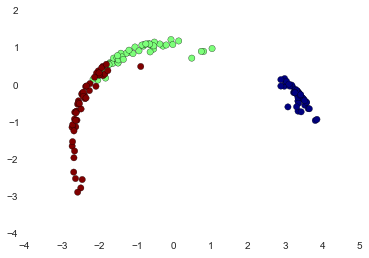

In [660]:
kpca = sklearn.decomposition.PCA(n_components=2)
kpca.fit(k)
kpca_result = kpca.transform(k)
plt.scatter(kpca_result[:,0], kpca_result[:,1], c=iris.target, cmap='jet', s=40)


Note that this is obviously a *non-rigid* transformation of the original dataset. We can compare standard PCA on the original features.

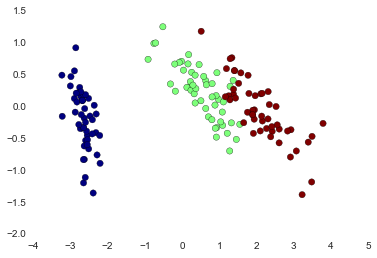

In [633]:
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(iris.data)
pca_result = pca.transform(iris.data)
plt.scatter(pca_result[:,0], pca_result[:,1], c=iris.target, cmap='jet', s=40)

### Non-real data: bag-of-words
A huge advantage of kernel based methods is that they do **not** need real valued data and they can work with models where computing the feature . All they need is a well behaved distance function. For example, we can perform dimensional reduction on text documents by defining a metric between two documents $d_i$ and $d_j$. 

A very simple, but very effective metric is *bag of words* -- simply creating a binary vector of the words (1 if a word occurs, 0 if it doesn't) that occur in one document and taking the intersection with those that occur in the other. We don't need to store these or even compute the set of all words -- we can just compute the documents as needed. Other binary vector metrics such as the cosine distance can be used in the same way. 

We can also replace the binary values with the count of words in the document to weight words that occur often more heavily.





## Dealing with time-series
### Windowing
### Delay embedding
### Derivative information

### Stateful algortihms
#### Hidden markov model
#### Kalman filter
#### Particle filter